# Preamble

In [2]:
# from instrumental import Q_,u,instrument
# from instrumental.drivers.daq.ni import Task # NIDAQ,
# import numpy as np
# from time import time, sleep
from poling import *
%matplotlib notebook

ModuleNotFoundError: No module named 'data_io'

In [2]:
############# connect to instruments ###############

## connect to NIDAQ
# daq1 = instrument(module='daq.ni',serial=14995354,name='Dev1')
daq = instrument(module="daq.ni",serial=21146242,name="Dev2")
# daq = instrument('DAQ2_NIDAQ_USB-6259_21146242') # `daq2` in shg_microscope.py

ch_pulse_ctl  = daq.ao1
ch_trig       = daq.ao3

ch_pulse_ctl.write(Q_(0.001,"volt"))
ch_trig.write(Q_(0.001,"volt"))

daq.ai0.read()

3.0263933946385264 <Unit('volt')>

In [3]:
scope_params = {"visa_address":"USB0::0x1AB1::0x04CE::DS1ZA224211034::INSTR",
                "module":"scopes.rigol"}
scope = instrument(**scope_params)
print("manufacturer: " + scope.manufacturer)
print("model: " + scope.model)

manufacturer: RIGOL TECHNOLOGIES
model: DS1054Z


C:\ProgramData\Miniconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


In [20]:
dat1 = scope.get_data(ch=[1,2,4],max_num_pts=100000)

VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

<IPython.core.display.Javascript object>


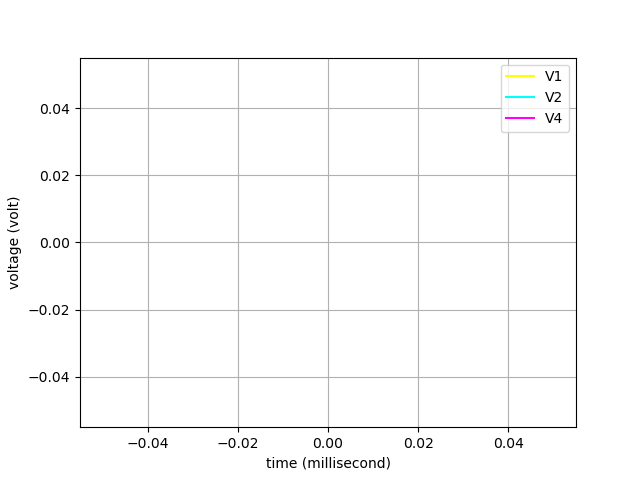

In [5]:
dat = dat1
x_unit = u.ms
y_unit = u.volt
colors = ['yellow','cyan','magenta','purple']

V_keys = [k  for k in dat.keys() if k[0]=='V']
fig,ax = plt.subplots(1,1)
for (idx,Vk) in enumerate(V_keys):
    ax.plot(dat['t'].m_as(x_unit),dat[Vk].m_as(y_unit),label=Vk,color=colors[idx])
plt.legend()
ax.grid()
ax.set_xlabel("time (%s)" % str(x_unit))
ax.set_ylabel("voltage (%s)" % str(y_unit))
plt.show()

# function definitions

In [65]:
# define parameterized pulse sequence fn

# Configure DAQ output channels for 
daq_Vout_ch, daq_Vout_ch_str = daq.ao1, 'Dev2/ao1'
daq_Vtrig_ch, daq_Vtrig_ch_str = daq.ao3, 'Dev2/ao3'


def poling_pulses(amp_init=200*u.volt,n_init=10,amp_final=250*u.volt,gain=80,f_samp=100*u.kHz,negate=False,
                 rise_time=1*u.ms,hold_time=1*u.ms,fall_time=1*u.ms,trigger_delay=1*u.ms,end_time=1*u.ms):
    t_pulse = rise_time + hold_time + fall_time # single polarity pulse
    t_end = trigger_delay + t_pulse * (2*n_init + 1) + end_time
    #t_end = ( ( 6 * n_init ) + 10 ) * u.ms
    t = np.linspace(0,t_end.m_as(u.ms), int((t_end*f_samp).to(u.dimensionless).m) + 1) * u.ms
    V = np.zeros(len(t))*u.volt
    
    def f_init_up0(tt):
        return (tt * amp_init/rise_time.m_as(u.ms) ).to(u.volt)
    
    def f_init_down0(tt):
        return  ( ( ( t_pulse.m_as(u.ms) - tt ) ) * amp_init/fall_time.m_as(u.ms) ).to(u.volt).m
    
    def f_init_down1(tt):
        return  ( ( ( t_pulse.m_as(u.ms) - tt ) ) * amp_init/rise_time.m_as(u.ms) ).to(u.volt).m
    
    def f_init_up1(tt):
        return  ( ( ( -2*t_pulse.m_as(u.ms) + tt ) ) * amp_init/fall_time.m_as(u.ms) ).to(u.volt).m
        #         return  ( ( ( -2*t_pulse.m_as(u.ms) + tt ) ) * amp_init ).to(u.volt).m

    
    def f_final_up(tt):
        return (tt * amp_final/rise_time.m_as(u.ms)).to(u.volt).m
    
    def f_final_down(tt):
        return  ( ( ( t_pulse.m_as(u.ms) - tt ) ) * amp_final/fall_time.m_as(u.ms) ).to(u.volt).m
    
    t_rel1 = rise_time.m_as(u.ms)
    t_rel2 = (rise_time+hold_time).m_as(u.ms)
    t_rel3 = (rise_time+hold_time+fall_time).m_as(u.ms)
    t_rel4 = (2*rise_time+hold_time+fall_time).m_as(u.ms)
    t_rel5 = (2*rise_time+2*hold_time+fall_time).m_as(u.ms)
    t_rel6 = (2*rise_time+2*hold_time+2*fall_time).m_as(u.ms)
    # loop over init pulse pairs
    for i in range(n_init):
        t_mask = ( t > (trigger_delay + i * 2 * t_pulse ) ) *  ( t < (trigger_delay + (i+1) * 2 * t_pulse ) ) 
        t_rel = t[t_mask].m_as(u.ms) - np.min(t[t_mask].m_as(u.ms))
        init_pulses = np.piecewise(t_rel,
                                   [t_rel<t_rel1,(t_rel>=t_rel1)*(t_rel<t_rel2),(t_rel>=t_rel2)*(t_rel<t_rel3),(t_rel>=t_rel3)*(t_rel<t_rel4),(t_rel>=t_rel4)*(t_rel<t_rel5),t_rel>=t_rel5],
                                   [f_init_up0,amp_init.m,f_init_down0,f_init_down1,-amp_init.m,f_init_up1],
                                  )
        V[t_mask] = init_pulses * u.volt
    # add final poling pulse
    t_mask = ( t >= ( trigger_delay + n_init * 2 * t_pulse ) ) * ( t < ( trigger_delay + ( n_init + 0.5 ) * 2 * t_pulse ) )  
    t_rel = t[t_mask].m - np.min(t[t_mask].m)
    final_pulse = np.piecewise(t_rel,
                               [t_rel<t_rel1,(t_rel>=t_rel1)*(t_rel<t_rel2),t_rel>=t_rel2],
                               [f_final_up,amp_final.m,f_final_down],
                              )
    V[t_mask] = final_pulse * u.volt
    if negate:
        return t, -V/gain
    else:
        return t, V/gain




def configure_pulse_task(t,V,Vout_ch=daq_Vout_ch,Vtrig_ch=daq_Vtrig_ch,
                             Vout_ch_str=daq_Vout_ch_str,Vtrig_ch_str=daq_Vtrig_ch_str):
    V_trigger = np.ones(len(V)) * 5*u.volt
    V_trigger[0] = 0.001*u.volt
    V_trigger[-1] = 0.001*u.volt
    fsamp = (1.0/(t[1] - t[0])).to(u.kHz)
    task = Task(
        Vout_ch,
        Vtrig_ch,
    )
    task.set_timing(fsamp=fsamp,n_samples=len(V))
    write_data = {
        Vout_ch_str :   V,
        Vtrig_ch_str :   V_trigger,
    }
    return task, write_data

def apply_pulses(daq_Vout_ch=daq.ao1,scope_Vout_ch=1,scope_Vamp_ch=2,rise_time=1*u.ms,hold_time=1*u.ms,fall_time=1*u.ms,
                 amp_init=600*u.volt,n_init=6,amp_final=450*u.volt,gain=80,f_samp=100*u.kHz,negate=False,trigger_delay=1*u.ms,end_time=1*u.ms,
                Vout_ch=daq_Vout_ch,Vtrig_ch=daq_Vtrig_ch,Vout_ch_str=daq_Vout_ch_str,Vtrig_ch_str=daq_Vtrig_ch_str):
    
    t_out, V_out = poling_pulses(amp_init=amp_init,n_init=n_init,amp_final=amp_final,gain=gain,f_samp=f_samp,trigger_delay=trigger_delay,end_time=end_time,negate=negate)
    task, write_data = configure_pulse_task(t_out,V_out,Vout_ch=Vout_ch,Vtrig_ch=Vtrig_ch,Vout_ch_str=Vout_ch_str,Vtrig_ch_str=Vtrig_ch_str)
#     scope.single_acq()
    sleep(0.2)
    read_data = task.run(write_data)
    task.unreserve()
#     Vtrig_ch.write(0.001*u.volt)
    scope_data = scope.get_data(ch=[1,2,4],max_num_pts=100000,t_wait=0.1,)
    scope.write(":run")
    return t_out, V_out, scope_data, write_data, read_data


In [15]:
# daq.close()

In [22]:
scope.write("RUN")

In [33]:
daq.ao3.write(0.001*u.volt)

In [78]:
t_out, V_out, scope_data, write_data, read_data = apply_pulses(amp_init=600*u.volt,n_init=9,amp_final=450*u.volt,negate=False)

C:\ProgramData\Miniconda3\lib\site-packages\numpy\lib\function_base.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y[cond] = func(vals, *args, **kw)


<IPython.core.display.Javascript object>


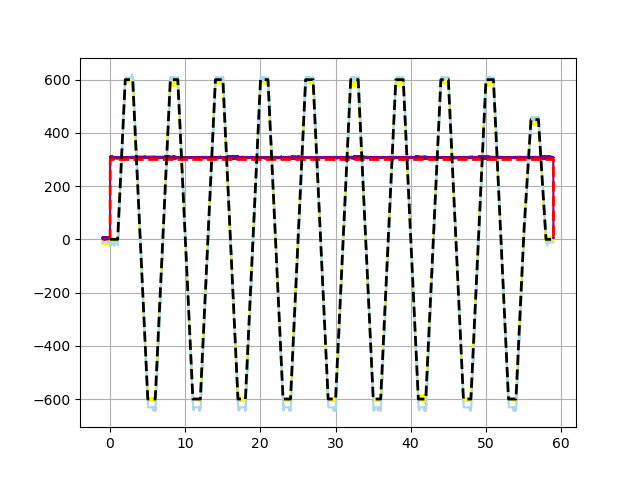

In [79]:
trigger_delay=1*u.ms

t_scope = scope_data["t"]
V_trig = write_data["Dev2/ao3"].m_as(u.volt)
V_out_scope = scope_data["V1"].m_as(u.volt)
V_amp_scope = scope_data["V2"].m_as(u.volt)
V_trig_scope = scope_data["V4"].m_as(u.volt)
t_scope_ms = t_scope.m_as(u.ms) # (t_scope + trigger_delay).m_as(u.ms)

fig,ax = plt.subplots(1,1)
C1 = 'yellow'
C2 = 'lightblue'
C4 = 'purple'
gain = 80


ax.plot(t_scope_ms,V_out_scope*gain,color=C1)
ax.plot(t_scope_ms,V_amp_scope,color=C2)
ax.plot(t_scope_ms,V_trig_scope*60,color=C4)

ax.plot(t_out.m_as(u.ms),V_trig*60,'r--',lw=2)
ax.plot(t_out.m_as(u.ms),V_out.m_as(u.volt)*gain,'k--',lw=2)
ax.grid()


C:\ProgramData\Miniconda3\lib\site-packages\numpy\lib\function_base.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y[cond] = func(vals, *args, **kw)


<IPython.core.display.Javascript object>


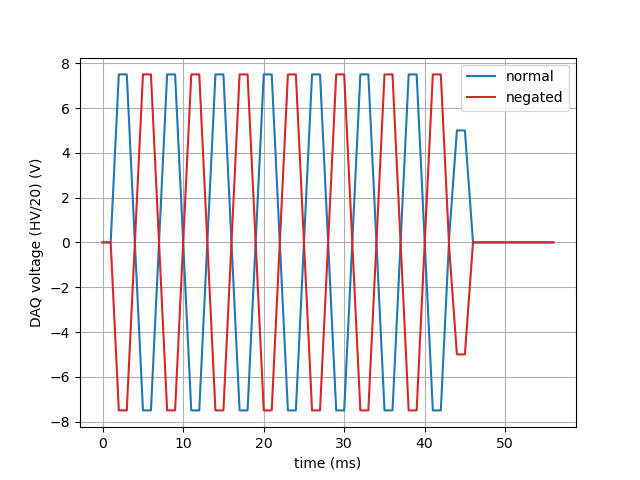

In [251]:
amp_init=600*u.volt
amp_final=400*u.volt
n_init = 7
tp,Vp = poling_pulses(n_init=n_init,amp_init=amp_init,amp_final=amp_final,gain=80,rise_time=1*u.ms,hold_time=1*u.ms,fall_time=1*u.ms,trigger_delay=1*u.ms)
tn,Vn = poling_pulses(n_init=n_init,amp_init=amp_init,amp_final=amp_final,gain=80,rise_time=1*u.ms,hold_time=1*u.ms,fall_time=1*u.ms,trigger_delay=1*u.ms,negate=True)
fig,ax = plt.subplots(1,1)
ax.plot(tp.m_as(u.ms),Vp.m_as(u.V),'-',color='C0',label='normal')
ax.plot(tn.m_as(u.ms),Vn.m_as(u.V),'-',color='C3',label='negated')
ax.set_xlabel('time (ms)')
ax.set_ylabel('DAQ voltage (HV/20) (V)')
ax.grid(True)
ax.legend()

In [95]:
scope.write("STOP")
scope.write(":FUNCtion:WRECord:ENABle 0")
scope.write(":FUNCtion:WRECord:ENABle 1")
scope.write("SINGLE")
# scope.write("RUN")

In [97]:
scope.write("RUN")

In [98]:
scope.write("SINGLE")

In [126]:
daq_Vout_ch_str

'Dev2/ao1'

In [254]:
V_trigger = np.ones(len(Vp)) * 5*u.volt
fsamp = 100*u.kHz #(1.0/(t[1] - t[0])).to(u.kHz)
task = Task(
    daq_Vout_ch,
    daq_Vtrig_ch,
)
task.set_timing(fsamp=fsamp,n_samples=len(Vp))

write_data = {
    daq_Vout_ch_str :   Vp,
    daq_Vtrig_ch_str :   V_trigger,
}

In [255]:
# scope.write("SINGLE")
# sleep(0.2)
# daq.ao1.write(Vp,duration=tp.max(),fsamp='100kHz')
read_data = task.run(write_data)
task.unreserve()
daq.ao3.write(0.01*u.volt)
sleep(0.1)
# t_scope, V_out_scope, V_amp_scope, V_trig_scope = get_scope_data(ch=[1,2,4])

t_scope, V_out_scope = scope.get_data(ch=1)
t_scope, V_amp_scope = scope.get_data(ch=2)
t_scope, V_trig_scope = scope.get_data(ch=4)
# V_out_scope = np.array(V_out_scope)
# V_amp_scope = np.array(V_amp_scope)
# V_trig_scope = np.array(V_trig_scope)


In [ ]:
t_off = (float(scope.query(':TIMebase:MAIN:OFFSet?'))*u.second).to(u.ms)
t_off

In [257]:
t_orig = (float(scope.query(':WAVeform:XORigin?'))*u.second).to(u.ms)
t_ref = (float(scope.query(':WAVeform:XREFerence?'))*u.second).to(u.ms)
t_inc = (float(scope.query(':WAVeform:XINCrement?'))*u.second).to(u.ms)


print("t_orig: ")
print(t_orig)

print("t_ref: ")
print(t_ref)

print("t_inc: ")
print(t_inc)


t_orig: 
-35.2 millisecond
t_ref: 
0.0 millisecond
t_inc: 
2e-05 millisecond


In [261]:
len(t_scope)

1200

In [262]:
len(V_out_scope)

1200

In [263]:
(t_scope[1]*u.second).to(u.ms) - (t_scope[0]*u.second).to(u.ms)

2e-05 <Unit('millisecond')>

<IPython.core.display.Javascript object>


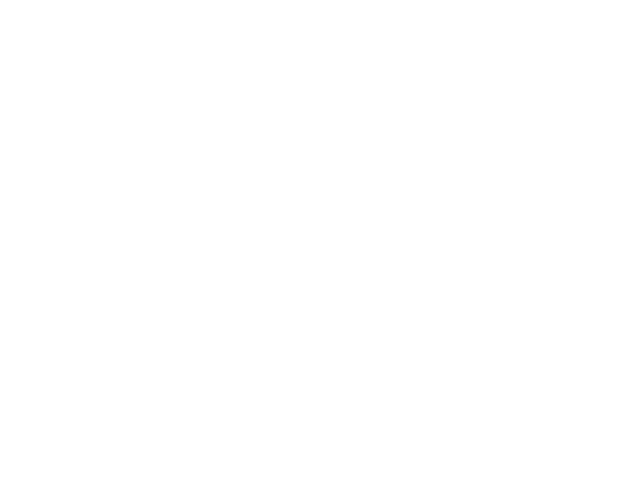

ValueError: x and y must have same first dimension, but have shapes (1200,) and (96000,)

In [264]:
trigger_delay=1*u.ms
t_scope_ms = (t_scope * u.second).m_as(u.ms) + t_orig.m_as(u.ms) + trigger_delay.m_as(u.ms)
fig,ax = plt.subplots(1,1)
C1 = 'yellow'
C2 = 'lightblue'
C4 = 'purple'
gain = 80
# ax.plot(t_out,V_out,color=C4)

ax.plot(t_scope_ms,V_out_scope*gain,color=C1)
ax.plot(t_scope_ms,V_amp_scope,color=C2)
ax.plot(tp,Vp*gain,'k--',lw=2)
ax.plot(t_scope_ms,V_trig_scope*60,color=C4)
ax.grid()

In [162]:
daq.ao3.write(0.01*u.volt)

In [222]:
len(V_out_scope)

1200

In [240]:
# scope.query(":ACQ:MDEPth?")
mem_depth_str = scope.query(":ACQ:MDEPth?")
int(mem_depth_str)


6000000

In [249]:
def get_scope_data(ch=[1,]):
        mem_depth_str = scope.query(":ACQ:MDEPth?")
        scope.write(":STOP")
        scope.write(f':WAV:SOUR CHAN{ch[0]}')
        scope.write(":WAVeform:MODE RAW")
        scope.write(":WAVeform:START 1")
        scope.write(":WAVeform:STOP "+mem_depth_str)
        sleep(0.1)
        data = scope._rsrc.query_binary_values(':WAVeform:DATA?', datatype='B', data_points=int(mem_depth_str))

        yinc = scope.yinc # Don't query multiple times
        yref = scope.yref
        yorig = scope.yorig
        xincr = scope.xincr

        Volts = (np.array([(val - yorig - yref) * yinc for val in data])*u.volt, )
        Time = (np.arange(0, xincr * len(Volts[0]), xincr)*u.second).to(u.ms)
        
        for chindx in ch:
            scope.write(f':WAV:SOUR CHAN{ch[chindx]}')
            scope.write(":WAVeform:MODE RAW")
            scope.write(":WAVeform:START 1")
            scope.write(":WAVeform:STOP "+mem_depth_str)
            sleep(0.1)
            data = scope._rsrc.query_binary_values(':WAVeform:DATA?', datatype='B', data_points=int(mem_depth_str))

            yinc = scope.yinc # Don't query multiple times
            yref = scope.yref
            yorig = scope.yorig
#             xincr = scope.xincr

            Volts += (np.array([(val - yorig - yref) * yinc for val in data])*u.volt,)
        

        scope.write(":RUN")
        return Time, Volts

In [267]:
mem_depth_str = scope.query(":ACQ:MDEPth?")
# scope.write(":STOP")
scope.write(f':WAV:SOUR CHAN1')
scope.write(":WAVeform:MODE RAW")
scope.write(":WAVeform:START 1")
scope.write(":WAVeform:STOP "+mem_depth_str)


In [268]:
data = scope._rsrc.query_binary_values(':WAVeform:DATA?', datatype='B', data_points=int(mem_depth_str))

VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

In [265]:
t1,V1 = get_scope_data(ch=[1,])

VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

<IPython.core.display.Javascript object>


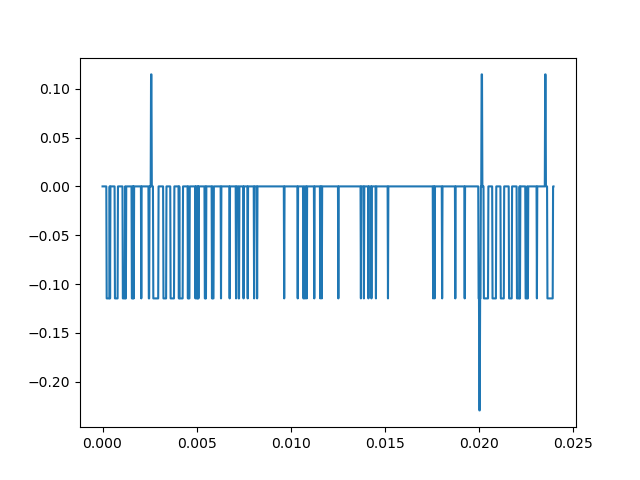

In [236]:
fig,ax = plt.subplots(1,1)
ax.plot(t1.m,V1[0].m)
plt.show()

In [248]:

# len(t_scope) * (50*u.us).to(u.ms)

scope._rsrc.timeout = 10000

In [245]:
scope._rsrc.timeout

20000

In [214]:
wfm_mode = scope.query(":WAVeform:MODE?")
wfm_mode

'RAW'

In [213]:
scope.write(":WAVeform:MODE RAW")

In [209]:
(1.0 / (5e7 /u.second)).to(u.ms) * 6e6

120.00000000000001 <Unit('millisecond')>

In [87]:

daq.ao1.write(Vp,duration=tp.max(),fsamp='100kHz')
while True:  # 1 means that the acquisition is still running
    sleep(0.5)
    if scope.query(":FUNCtion:WRECord:OPERate?") == "STOP":
        scope.write(":FUNCtion:WRECord:ENABle 0")
        break


In [ ]:

def process_scan(read_data,nx,ny,ΔVx,ΔVy,Vx0=Vx0,Vy0=Vy0):
    t = read_data['t']
    Vshg_x = read_data[ch_Vshg_x_str]
    Vshg_y = read_data[ch_Vshg_y_str]
    # Vpm  = read_data[ch_Vpm_str]
    Vx_meas = read_data[ch_Vx_meas_str]
    Vy_meas = read_data[ch_Vy_meas_str]
    # Vx_scan = write_data[ch_Vx_p_str] - write_data[ch_Vx_n_str]
    # Vy_scan = write_data[ch_Vy_p_str] - write_data[ch_Vy_n_str]
    Vx,Vy = scan_vals(nx,ny,ΔVx,ΔVy,Vx0,Vy0)
    Vx_g, Vy_g = np.meshgrid(Vx.m,Vy.m)
    Vshg_x_g = griddata((Vx_meas.m,Vy_meas.m),Vshg_x.m,(Vx_g,Vy_g))*u.volt
    Vshg_y_g = griddata((Vx_meas.m,Vy_meas.m),Vshg_y.m,(Vx_g,Vy_g))*u.volt
    proc_data = {
        "Vx"      : Vx,
        "Vy"      : Vy,
        "dx_dVx"  : dx_dVx,
        "dy_dVy"  : dy_dVy,
        "x"       : ((Vx-Vx0)*dx_dVx).to(u.um),
        "y"       : ((Vy-Vy0)*dy_dVy).to(u.um),
        "Vshg_x_g": Vshg_x_g,
        "Vshg_y_g": Vshg_y_g,
    }
    return proc_data

def collect_scan(nx,ny,ΔVx,ΔVy,Vx0,Vy0,fsamp,name=None,sample_dir=None,wf_exposure_time=3*u.ms):
    maximize_excitation_power()
    sample_dir = resolve_sample_dir(sample_dir)
    fpath = new_path(name=name,data_dir=sample_dir,ds_type='GalvoScan',extension='h5',timestamp=True)
    print("saving data to: ")
    print(fpath)
    θ_pow_hwp   = pow_hwp.position
    θ_pol_hwp   = pol_hwp.get_position()
    P_ex        = get_excitation_power()
    wf_img, laser_spot_img = wf_and_laser_spot_images(exposure_time=wf_exposure_time)
    x_img,y_img = img_spatial_axes(laser_spot_img)
    dump_hdf5(
        {   'wf_img': wf_img.astype("int"),
            'laser_spot_img': laser_spot_img.astype("int"),
            'dx_dpix': dx_dpix,
            'x_img': x_img,
            'y_img': y_img,
            'θ_pow_hwp': θ_pow_hwp,
            'θ_pol_hwp': θ_pol_hwp,
            'P_ex': P_ex,
        },
        fpath,
        open_mode='x',
    )
    scan_task, write_data = configure_scan(nx,ny,ΔVx,ΔVy,Vx0,Vy0,fsamp)
    dump_hdf5(write_data,fpath)
    read_data = scan_task.run(write_data)
    dump_hdf5(read_data,fpath)
    scan_task.unreserve()
    center_spot(Vx0,Vy0)
    proc_data = process_scan(read_data,nx,ny,ΔVx,ΔVy)
    dump_hdf5(proc_data,fpath)
    ds = load_hdf5(fpath=fpath)
    return ds


In [11]:
# oscilloscope convenience functions
def grab_traces(channels=[1,2]):
    scope.single_acq()
    t_V = [scope.get_data(ch=ch_i) for ch_i in channels]
    t = t_V[0][0]
    V = [tV[1] for tV in t_V]
    return t, V


                                         

In [29]:
(len(Vp) * (10 *u.us)).to(u.ms)
tp.max()

70.0 <Unit('millisecond')>

# function tests

C:\ProgramData\Miniconda3\lib\site-packages\numpy\lib\function_base.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y[cond] = func(vals, *args, **kw)


<IPython.core.display.Javascript object>


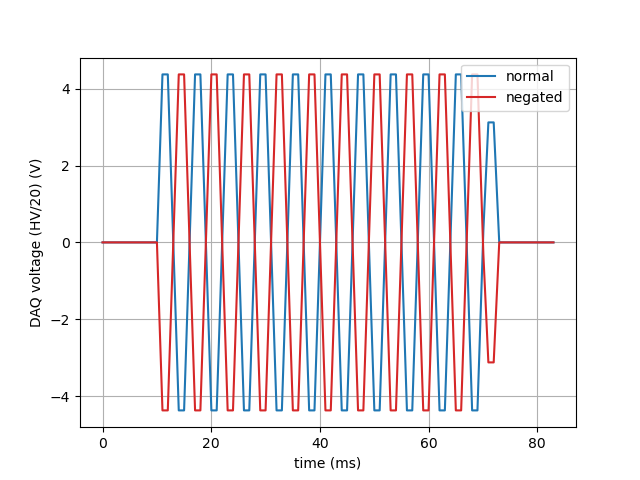

C:\ProgramData\Miniconda3\lib\site-packages\numpy\core\_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Miniconda3\lib\site-packages\numpy\core\_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


In [38]:
# test `poling_pulses`: compute and plot an example pulse sequence

amp_init=350*u.volt
amp_final=250*u.volt
tp,Vp = poling_pulses(amp_init=amp_init,amp_final=amp_final,gain=80)
tn,Vn = poling_pulses(amp_init=amp_init,amp_final=amp_final,gain=80,negate=True)
fig,ax = plt.subplots(1,1)
ax.plot(tp,Vp,'-',color='C0',label='normal')
ax.plot(tn,Vn,'-',color='C3',label='negated')
ax.set_xlabel('time (ms)')
ax.set_ylabel('DAQ voltage (HV/20) (V)')
ax.grid(True)
ax.legend()


C:\ProgramData\Miniconda3\lib\site-packages\numpy\lib\function_base.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y[cond] = func(vals, *args, **kw)


<IPython.core.display.Javascript object>


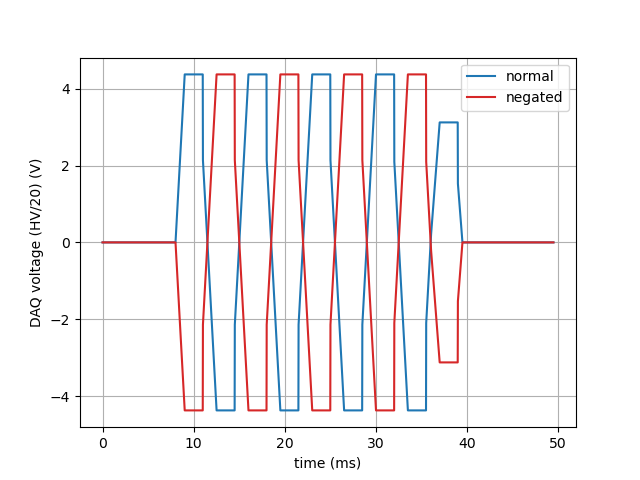

C:\ProgramData\Miniconda3\lib\site-packages\numpy\core\_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Miniconda3\lib\site-packages\numpy\core\_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


In [40]:
amp_init=350*u.volt
amp_final=250*u.volt
n_init = 4
tp,Vp = poling_pulses(n_init=n_init,amp_init=amp_init,amp_final=amp_final,gain=80,rise_time=1*u.ms,hold_time=2*u.ms,fall_time=0.5*u.ms,trigger_delay=8*u.ms)
tn,Vn = poling_pulses(n_init=n_init,amp_init=amp_init,amp_final=amp_final,gain=80,rise_time=1*u.ms,hold_time=2*u.ms,fall_time=0.5*u.ms,trigger_delay=8*u.ms,negate=True)
fig,ax = plt.subplots(1,1)
ax.plot(tp,Vp,'-',color='C0',label='normal')
ax.plot(tn,Vn,'-',color='C3',label='negated')
ax.set_xlabel('time (ms)')
ax.set_ylabel('DAQ voltage (HV/20) (V)')
ax.grid(True)
ax.legend()

In [70]:
t_out,V_out,t_scope,V_out_scope,V_amp_scope,write_data,read_data = apply_pulses(amp_init=300*u.volt,n_init=10,amp_final=250*u.volt,negate=False)

C:\ProgramData\Miniconda3\lib\site-packages\numpy\lib\function_base.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y[cond] = func(vals, *args, **kw)


<IPython.core.display.Javascript object>


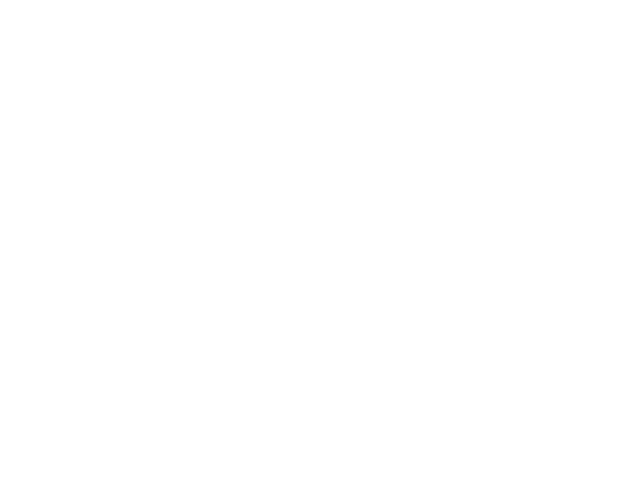

C:\ProgramData\Miniconda3\lib\site-packages\numpy\core\_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


ValueError: x and y must have same first dimension, but have shapes (1200,) and (96000,)

In [108]:
t_scope_ms = (t_scope * u.second).m_as(u.ms)
fig,ax = plt.subplots(1,1)
C1 = 'yellow'
C2 = 'lightblue'
C4 = 'purple'
gain = 80
# ax.plot(t_out,V_out,color=C4)
ax.plot(tp,gain*Vp,color=C4)
ax.plot(t_scope_ms,gain*V_out_scope,color=C1)
ax.plot(t_scope_ms,V_amp_scope,color=C2)
ax.grid()

Magnitude,[0.0 0.1 0.2 ... 119.7 119.8 119.9]
Units,millisecond


In [12]:
# test`grab_traces`: grab and plot oscilloscope data from channels

t, V = grab_traces(channels=[1,2])
V1,V2 = V

<IPython.core.display.Javascript object>


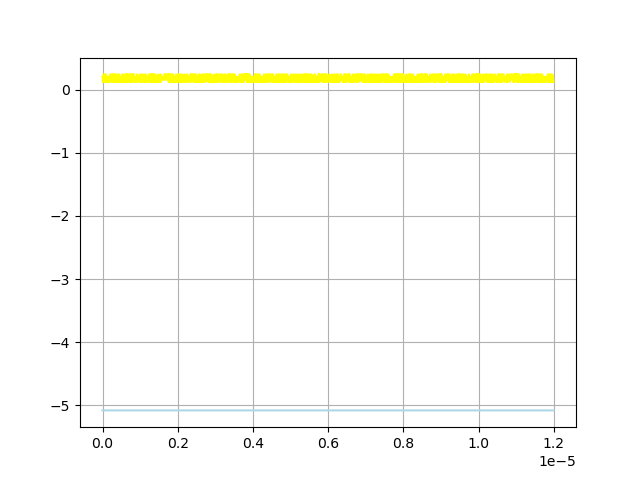

In [14]:
fig,ax = plt.subplots(1,1)
C1 = 'yellow'
C2 = 'lightblue'
C4 = 'purple'
ax.plot(t,V1,color=C1)
ax.plot(t,V2,color=C2)
ax.grid()

In [19]:
daq.ao1.write(Vp,duration='70ms',fsamp='100kHz')

In [ ]:
amp_init=400*u.volt
amp_final=100*u.volt
t,Vp = poling_pulses(amp_init=amp_init,amp_final=amp_final)
t,Vn = poling_pulses(amp_init=amp_init,amp_final=amp_final,negate=True)
fig,ax = plt.subplots(1,1)
ax.plot(t,Vp,'-',color='C0',label='normal')
ax.plot(t,Vn,'-',color='C3',label='negated')
ax.set_xlabel('time (ms)')
ax.set_ylabel('DAQ voltage (HV/20) (V)')
ax.grid(True)
ax.legend()

In [1]:
### Power supply ###
V_ps = 24.66 * u.volt

NameError: name 'u' is not defined

C:\ProgramData\Miniconda3\lib\site-packages\numpy\lib\function_base.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y[cond] = func(vals, *args, **kw)


<IPython.core.display.Javascript object>


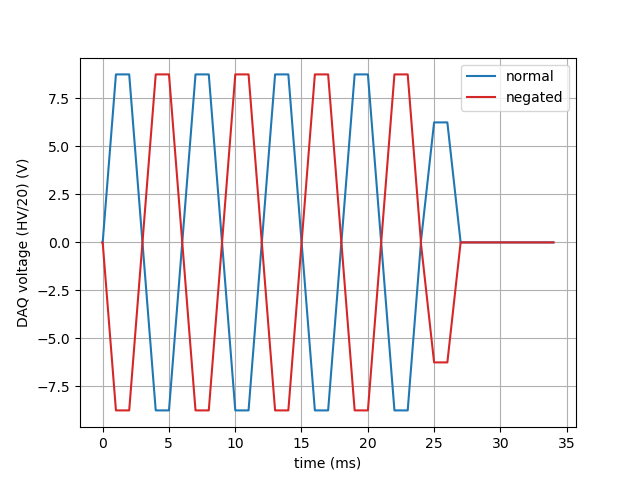

C:\ProgramData\Miniconda3\lib\site-packages\numpy\core\_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Miniconda3\lib\site-packages\numpy\core\_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


In [11]:
amp_init=350*u.volt
amp_final=250*u.volt
t,Vp = poling_pulses(amp_init=amp_init,n_init=4,amp_final=amp_final)
t,Vn = poling_pulses(amp_init=amp_init,n_init=4,amp_final=amp_final,negate=True)
fig,ax = plt.subplots(1,1)
ax.plot(t,Vp,'-',color='C0',label='normal')
ax.plot(t,Vn,'-',color='C3',label='negated')
ax.set_xlabel('time (ms)')
ax.set_ylabel('DAQ voltage (HV/20) (V)')
ax.grid(True)
ax.legend()

In [14]:
daq.ao1.write(Vn,duration='70ms',fsamp='100kHz')

In [7]:
daq.ai1.read()

DAQError: (-50808) A USB transfer failed due to a transaction error reported by the USB host controller.  This may be due to a fault in the system's USB host controller, a USB cable, or a USB device.
Task Name: _unnamedTask<1>

Status Code: -50808